-Added 2 layers to autoencoder
-changed img input

In [1]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image, ImageChops
from sklearn.neighbors import KernelDensity
import random
import shutil
import tensorflow as tf

import glob

In [ ]:
% matplotlib inline

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [42]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls   #check if mounted correctly

DATADIR = "/content/gdrive/My Drive/gpu_autoencoder_2/train"
os.listdir('/content/gdrive/My Drive/gpu_autoencoder_2/train')     #show directories in base directory

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
file1.zip  gpu_encoded_images_flat.csv	gpu_val_enc_flat.csv
file.zip   gpu_stress_autoencoder	models
gdrive	   gpu_stress_encoder		sample_data


['idle_gpu_autoencoder', 'gpu_stress_autoencoder']

In [4]:
Classes = ["idle","cpu_stress"]

In [6]:
import random
for cl in Classes:
  img_path = os.path.join(DATADIR, cl)    # Merge DATADIR with class name
  print(img_path)
  images = glob.glob(img_path + '/*.jpg')   # Take path name and include everything with .jpg. Return list of all images
  random.shuffle(images)                    # randomly shuffle list
  print("{}: {} Images". format(cl,len(images)))
  num_train = int(round(len(images)*0.7))     # Find what 70% of images is
  train, val = images[:num_train], images[num_train:]   # Assign 70% and 30% of images to training and validation datasets respectively. list starting at index 0 up to but not including num_train

  for t in train:
    if not os.path.exists(os.path.join(DATADIR, 'train', cl)):
      os.makedirs(os.path.join(DATADIR, 'train', cl))
    shutil.move(t, os.path.join(DATADIR, 'train', cl))      # Move images to train directory

  for v in val:
    if not os.path.exists(os.path.join(DATADIR, 'val', cl)):
      os.makedirs(os.path.join(DATADIR, 'val', cl))
    shutil.move(v, os.path.join(DATADIR, 'val', cl))        #Move images to val director

/content/gdrive/My Drive/gpu_autoencoder_2/train/idle
idle: 400 Images
/content/gdrive/My Drive/gpu_autoencoder_2/train/cpu_stress
cpu_stress: 400 Images


In [7]:
batch_size = 64
IMG_width = 160
IMG_height= 160

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/My Drive/gpu_autoencoder_2/train/idle_gpu_autoencoder',
    target_size=(IMG_height, IMG_width),
    batch_size=batch_size,
    class_mode='input'
    )

val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
validation_generator = val_datagen.flow_from_directory(
    '/content/gdrive/My Drive/gpu_autoencoder_2/val/idle_gpu_autoencoder',
    target_size=(IMG_height, IMG_width),
    batch_size=batch_size,
    class_mode='input'      #Use for Autoencoders because there is one class, its input and output
    )

anomaly_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
anomaly_generator = anomaly_datagen.flow_from_directory(
    '/content/gdrive/My Drive/gpu_autoencoder_2/train/gpu_stress_autoencoder',
    target_size=(IMG_height, IMG_width),
    batch_size=batch_size,
    class_mode='input'
    )

images = glob.glob('/content/gdrive/My Drive/gpu_autoencoder_2/train/idle_gpu_autoencoder/idle_gpu' + '/*.jpg')   # Take path name and include everything with .jpg. Return list of all images
print("{}: {} Images". format('train:idle_gpu_autoencoder',len(images)))

images = glob.glob('/content/gdrive/My Drive/gpu_autoencoder_2/val/idle_gpu_autoencoder/idle_gpu' + '/*.jpg')   # Take path name and include everything with .jpg. Return list of all images
print("{}: {} Images". format('val:idle_gpu_autoencoder',len(images)))

images = glob.glob('/content/gdrive/My Drive/gpu_autoencoder_2/train/gpu_stress_autoencoder/gpu_stress' + '/*.jpg')   # Take path name and include everything with .jpg. Return list of all images
print("{}: {} Images". format('test:gpu_stress_autoencoder',len(images)))


Found 560 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
train:idle_gpu_autoencoder: 0 Images
val:idle_gpu_autoencoder: 0 Images
test:gpu_stress_autoencoder: 400 Images


In [11]:
# Define the convolutional autoencoder model 
# input shape must be the same size as the images that will be fed into it by the generators
# The output layer must be the same dimensions as the original image
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same',activation='relu', input_shape=(IMG_height, IMG_width, 3)))
model.add(MaxPooling2D(pool_size=(2,2), padding='same')) # using pool_size (2,2) makes the layer 2x smaller in height and width

model.add(Conv2D(8,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#-------------------------

model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(8,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(16,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3,(3, 3), activation='sigmoid', padding='same'))
#-------------------------

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 3)         219       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 3)         8

In [13]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# Training the model
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20) # Early stopping (stops training when validation doesn't improve for {patience} epochs).  min_delta=1 to abort if improvement is less than 1%. verbose displayes last epoch
model_filepath = 'models/gpu_stress_autoencoder_v5.keras'
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min',  verbose=1) # Saves the best version of the model to disk (as measured on the validation data set)
model.fit(
        train_generator,        #add accuracy metric
        steps_per_epoch=int(np.ceil(train_generator.n / float(batch_size))),
        epochs=600,
        validation_data=validation_generator,
        validation_steps=int(np.ceil(validation_generator.n / float(batch_size))),
        shuffle = True,
        callbacks=[es, save_best])

Epoch 1/600
9/9 [==============================] - 176s 16s/step - loss: 0.0773 - val_loss: 0.0421

Epoch 00001: val_loss improved from inf to 0.04207, saving model to models/gpu_stress_autoencoder_v5.keras
Epoch 2/600
9/9 [==============================] - 2s 218ms/step - loss: 0.0336 - val_loss: 0.0250

Epoch 00002: val_loss improved from 0.04207 to 0.02499, saving model to models/gpu_stress_autoencoder_v5.keras
Epoch 3/600
9/9 [==============================] - 2s 224ms/step - loss: 0.0229 - val_loss: 0.0188

Epoch 00003: val_loss improved from 0.02499 to 0.01884, saving model to models/gpu_stress_autoencoder_v5.keras
Epoch 4/600
9/9 [==============================] - 2s 227ms/step - loss: 0.0179 - val_loss: 0.0164

Epoch 00004: val_loss improved from 0.01884 to 0.01641, saving model to models/gpu_stress_autoencoder_v5.keras
Epoch 5/600
9/9 [==============================] - 2s 218ms/step - loss: 0.0159 - val_loss: 0.0154

Epoch 00005: val_loss improved from 0.01641 to 0.01543, savi

In [17]:
# Training continues after improvement stops for the number of epochs equivalent to the 'patience' hyper-parameter
# To get back the model that performed best on the validation set we load the checkpointed model from disk:
model = keras.models.load_model(model_filepath)

In [18]:
model_filepath      #check model name

'models/gpu_stress_autoencoder_v5.keras'

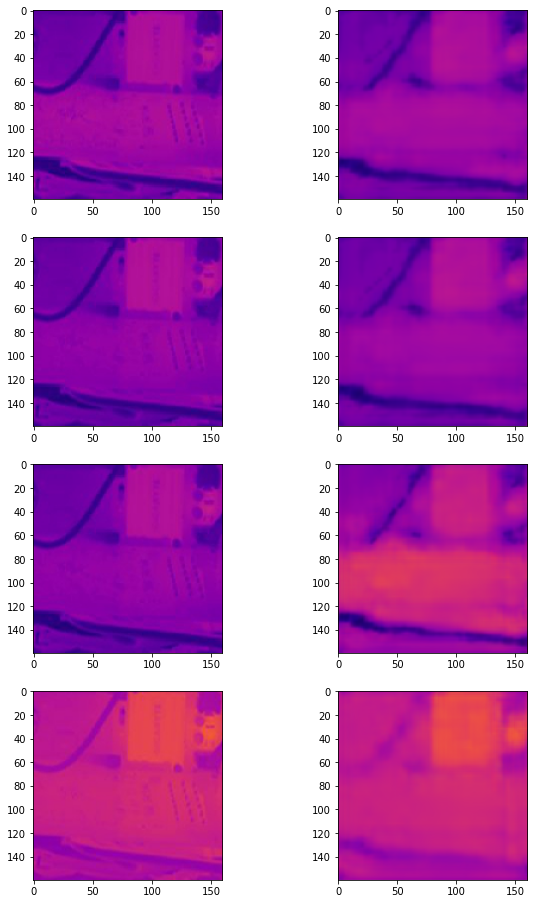

In [19]:
# Test the model by viewing a sample of original and reconstructed images of training dataset 
data_list = []
batch_index = 0
while batch_index <= train_generator.batch_index:
    data = train_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

predicted = model.predict(data_list[0])
no_of_samples = round(len(train_generator)/2)    #3 because thats how many objects in train_generator iterator
_, axs = plt.subplots(nrows=no_of_samples, ncols=2, figsize=(10, 16))   #axs is the location of the fig

axs = axs.flatten()
imgs = []
for i in range(no_of_samples):    
    imgs.append(data_list[i][i])
    imgs.append(predicted[i])


for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

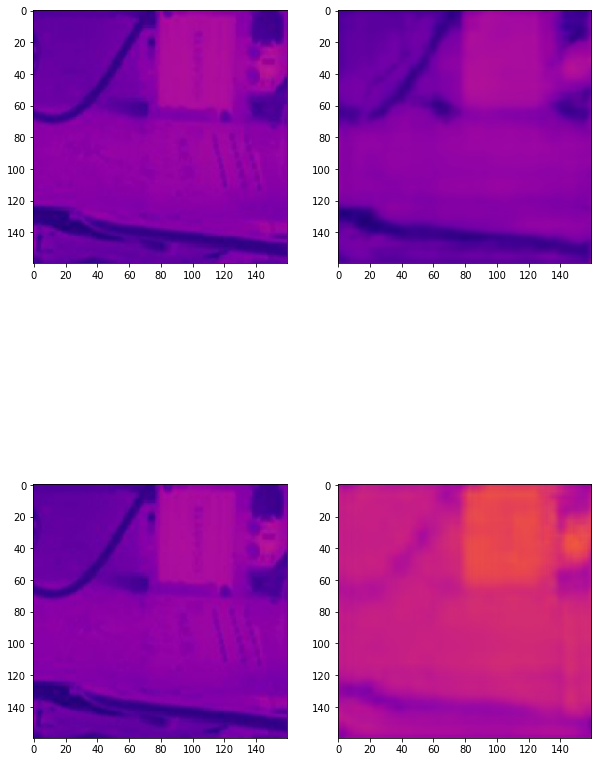

In [20]:
# Test the model by viewing a sample of original and reconstructed images of validation dataset
data_list = []
batch_index = 0
while batch_index <= validation_generator.batch_index:
    data = validation_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

predicted = model.predict(data_list[0])
no_of_samples = round(len(validation_generator)/2)        #3 because thats how many objects in train_generator iterator
_, axs = plt.subplots(nrows=no_of_samples, ncols=2, figsize=(10, 16))   #axs is the location of the fig

axs = axs.flatten()
imgs = []
for i in range(no_of_samples):    
    imgs.append(data_list[i][i])
    imgs.append(predicted[i])


for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

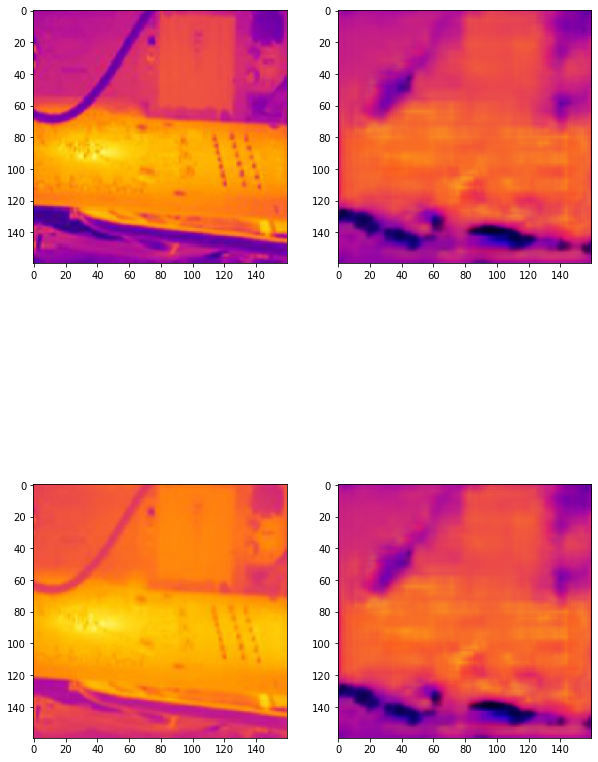

In [21]:
# Test the model by viewing a sample of original and reconstructed images of anomaly dataset
data_list = []
batch_index = 0
while batch_index <= anomaly_generator.batch_index:
    data = anomaly_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

predicted = model.predict(data_list[0])
no_of_samples = 4     #3 because thats how many objects in train_generator iterator
_, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 16))   #axs is the location of the fig

axs = axs.flatten()
imgs = []
for i in range(no_of_samples):    
    imgs.append(data_list[i][i])
    imgs.append(predicted[i])


for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [22]:

# We want the difference the difference in error between the validation (normal) images and anomalous images to be as high as possible
print(f"Error on validation set:{model.evaluate(validation_generator)}, error on anomaly set:{model.evaluate(anomaly_generator)}")

13/13 [==============================] - 2s 142ms/step - loss: 0.0206
Error on validation set:0.0007944820681586862, error on anomaly set:0.020607752725481987


In [23]:
# We build a replica of the first half of the auto-encoder (the encoder only)
# This network takes a an image which is 96x96x3 and compresses it down to a 3x3x3 tensor
encoder_replica = Sequential()
encoder_replica.add(Conv2D(16, (3, 3), padding='same',activation='relu', input_shape=(IMG_height, IMG_width, 3), weights=model.layers[0].get_weights(), name='encoder_conv_1') )    #get weights from original model
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same', name='encoder_maxpool_1'))
encoder_replica.add(Conv2D(8,(3, 3),activation='relu',  padding='same', weights=model.layers[2].get_weights(), name='encoder_conv_2'))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same', name='encoder_maxpool_2'))
encoder_replica.add(Conv2D(3,(3, 3),activation='relu',  padding='same', weights=model.layers[4].get_weights(), name='encoder_conv_3'))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same', name='encoder_maxpool_3'))
encoder_replica.add(Conv2D(3,(3, 3),activation='relu',  padding='same', weights=model.layers[6].get_weights(), name='encoder_conv_4'))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same', name='encoder_maxpool_4'))
encoder_replica.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_conv_1 (Conv2D)      (None, 160, 160, 16)      448       
_________________________________________________________________
encoder_maxpool_1 (MaxPoolin (None, 80, 80, 16)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 80, 80, 8)         1160      
_________________________________________________________________
encoder_maxpool_2 (MaxPoolin (None, 40, 40, 8)         0         
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 40, 40, 3)         219       
_________________________________________________________________
encoder_maxpool_3 (MaxPoolin (None, 20, 20, 3)         0         
_________________________________________________________________
encoder_conv_4 (Conv2D)      (None, 20, 20, 3)        

In [24]:
encoder_replica.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
encoder_replica.save("gpu_stress_encoder")

INFO:tensorflow:Assets written to: gpu_stress_encoder/assets


In [26]:
#zip a folder under /content/Folder_To_Zip
!zip -r /content/file.zip  /content/gpu_stress_encoder

  adding: content/gpu_stress_encoder/ (stored 0%)
  adding: content/gpu_stress_encoder/saved_model.pb (deflated 91%)
  adding: content/gpu_stress_encoder/assets/ (stored 0%)
  adding: content/gpu_stress_encoder/variables/ (stored 0%)
  adding: content/gpu_stress_encoder/variables/variables.data-00000-of-00001 (deflated 30%)
  adding: content/gpu_stress_encoder/variables/variables.index (deflated 54%)


In [27]:
model.save("gpu_stress_autoencoder")

INFO:tensorflow:Assets written to: gpu_stress_autoencoder/assets


In [28]:
#zip a folder under /content/Folder_To_Zip
!zip -r /content/file1.zip  /content/gpu_stress_autoencoder

  adding: content/gpu_stress_autoencoder/ (stored 0%)
  adding: content/gpu_stress_autoencoder/saved_model.pb (deflated 90%)
  adding: content/gpu_stress_autoencoder/assets/ (stored 0%)
  adding: content/gpu_stress_autoencoder/variables/ (stored 0%)
  adding: content/gpu_stress_autoencoder/variables/variables.data-00000-of-00001 (deflated 27%)
  adding: content/gpu_stress_autoencoder/variables/variables.index (deflated 73%)


In [29]:
# get dimensions of the last layer of 'encoder_replica' model
layer=encoder_replica.get_layer('encoder_maxpool_4')
layer_list=layer.get_output_at(0).get_shape().as_list()
dim= layer_list[1]*layer_list[2]*layer_list[3]



print("Last layer has dimensions: {}*{}*{}". format(layer_list[1],layer_list[2],layer_list[3]))
print("Product of layer dimensions: {}". format(dim))


Last layer has dimensions: 10*10*3
Product of layer dimensions: 300


In [30]:
# Creating encoded (compressed versions of the training, validation and anomalous images) and getting their density
# The SKLearn kernel density function only works with 1D arrays so we need to flatten the tensors created by the encoder

encoded_images = encoder_replica.predict(train_generator)
encoded_images_flat = [np.reshape(img, (dim)) for img in encoded_images]      #to get the second argument multiply the dimensions in encoded_images: 12*12*3=432. Do this to flatten image

validation_encoded = encoder_replica.predict(validation_generator)
val_enc_flat = [np.reshape(img, (dim)) for img in validation_encoded]

anom_encoded = encoder_replica.predict(anomaly_generator)
anom_enc_flat = [np.reshape(img, (dim)) for img in anom_encoded]

In [40]:
np.savetxt("gpu_encoded_images_flat.csv", encoded_images_flat, delimiter=",")
np.savetxt("gpu_val_enc_flat.csv", val_enc_flat, delimiter=",")

# my_data = np.genfromtxt('foo.csv', delimiter=',')

204.39781772099371
[203.56764969 203.92141656 202.14384079 203.51967335 205.23356546
 204.91999566 204.19363307 204.50263587 202.84141237 204.57726868
 205.28173192 203.62232712 204.96847675 203.25429909 204.54984105
 205.05598195 204.1273691  202.09881051 204.33161436 204.67278
 204.87003197 204.14917831 204.19709451 202.36070269 204.87027597
 203.31784343 204.53489151 205.17825281 203.88262106 203.00471797
 205.29984463 204.25850484 203.53300109 202.26945727 204.91966046
 204.49622791 203.34802424 202.44333373 203.70793122 202.65370314
 204.88703442 204.3003241  203.45952269 202.63184451 204.39274681
 204.89289414 204.36656176 202.79473038 204.73741703 204.10092482
 204.10128387 205.03746586 203.82122051 203.8444511  202.22841969
 205.23359377 204.93613272 205.30922181 201.82245315 205.22535017
 204.00979122 203.09527388 204.42517793 202.08902822 205.28097735
 204.56315697 205.28382527 204.15462501 205.01797925 204.85313206
 203.34383903 204.79720798 204.67229864 205.26467008 201.414

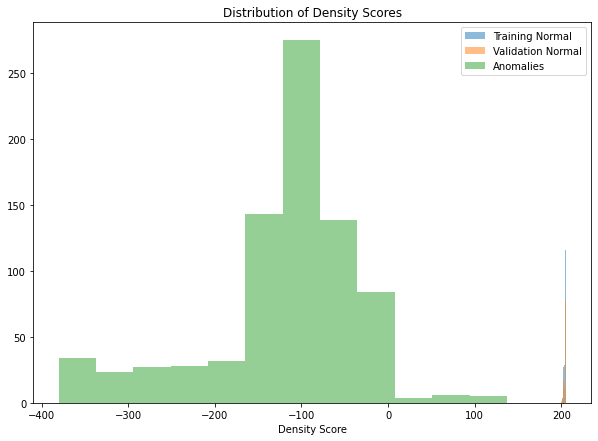

In [32]:

# Kernel Density Estimation of the encoded vectors
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_flat)        # kernel density is a tool used to make discrete values smooth. bandwidth is how smooth it is. kernel is the function used. check https://mathisonian.github.io/kde/
training_density_scores = kde.score_samples(encoded_images_flat) 
print(np.median(training_density_scores))
print(training_density_scores)

validation_density_scores = kde.score_samples(val_enc_flat)
print(np.median(validation_density_scores))
print(validation_density_scores)

anomaly_density_scores = kde.score_samples(anom_enc_flat)
print(np.median(anomaly_density_scores))
print(anomaly_density_scores)



# Plotting the density distributions of the training (normal), validation (normal) and anomalous images
# Ideally we want to see high separation between the normal and anomalous classes
plt.figure(figsize = (10,7))
plt.title('Distribution of Density Scores')
plt.hist(training_density_scores, 12, alpha=0.5, label='Training Normal')
plt.hist(validation_density_scores, 12, alpha=0.5, label='Validation Normal')
plt.hist(anomaly_density_scores, 12, alpha=0.5, label='Anomalies')
plt.legend(loc='upper right')
plt.xlabel('Density Score')

plt.show()

In [33]:
# sorted_validation_density_scores=np.sort(validation_density_scores)
# print(sorted_validation_density_scores)

min_quantile = np.quantile(validation_density_scores, 0.01)   #obtain 0.01 smallest value on validatation density score
max_quantile = np.quantile(validation_density_scores, 0.99)   #obtain 0.99 biggest value on validatation density score

min_quantile_threshold=min_quantile - 10          #change 10 to a number based on tolerance level
max_quantile_threshold= max_quantile + 10         #change 10 to a number based on tolerance level

In [34]:
# Create a function for classifying images in bulk (for testing purposes)
def get_mse(original, reconstruction):
    # Returns the mean square error for each image in the array
    return np.mean((original - reconstruction)**2, axis=(1,2,3)) 

def evaluate_model(test_file):
    # density_threshold = 175 # This threshold was chosen based on looking at the distribution of the density scores of the normal class (validation set)
    reconstruction_error_threshold = 0.020 # This threshold was chosen based on looking at the distribution of reconstruction errors of the normal class
    batch_size  = 0
    for (dirpath, dirnames, filenames) in os.walk(test_file):
        batch_size += len([file for file in filenames if file.endswith(".jpg")]) # Batchsize now is total images in folder
    
    test_img_generator = train_datagen.flow_from_directory(
    test_file,
    target_size=(IMG_height, IMG_width),
    batch_size=batch_size,
    class_mode='input'
    )
    
    images = test_img_generator.next()[0]   #load test images to variable images
    reconstructions = model.predict(images) #get reconstructed images
    MSEs = get_mse(images, reconstructions) #get mse
    reconstruction_anomalies = MSEs > reconstruction_error_threshold
    print(f'Reconstruction anomalies = {sum(reconstruction_anomalies)}')
    
    encoded_images = encoder_replica.predict(test_img_generator)
    encoded_images_flat = np.array([np.reshape(img, (dim)) for img in encoded_images])        #change argument (dim) to last layer dimensions product
    density_scores = kde.score_samples(encoded_images_flat)

    density_anomalies_min= density_scores < min_quantile_threshold      # check if desnity score is samller than threshold
    density_anomalies_max= density_scores > max_quantile_threshold      # check if desnity score is bigger than threshold
    density_anomalies = density_anomalies_min != density_anomalies_max    # get the resultant. example: density_anomalies_min= True,  density_anomalies_min= False ==> density_anomalies= True


    combined_anomalies = np.maximum(reconstruction_anomalies, density_anomalies)
    print(f'Combined anomalies = {sum(combined_anomalies)}')
    overall_detection_rate = sum(combined_anomalies) / len(combined_anomalies)
    print(f'Overall detection rate = {overall_detection_rate}')
    return  MSEs

In [35]:
# Check what proportion of normal images get classified as anomalous
MSE_normal=evaluate_model('/content/gdrive/My Drive/gpu_autoencoder_2/train/idle_gpu_autoencoder')

Found 560 images belonging to 2 classes.
Reconstruction anomalies = 0
Combined anomalies = 0
Overall detection rate = 0.0


In [36]:
# Check what proportion of validation images get classified as anomalous
MSE_val=evaluate_model('/content/gdrive/My Drive/gpu_autoencoder_2/val/idle_gpu_autoencoder')

Found 240 images belonging to 2 classes.
Reconstruction anomalies = 0
Combined anomalies = 0
Overall detection rate = 0.0


In [37]:
# Check what proportion of anomaly images (a set which was unseen in training) get classified as anomalous
MSE_anom=evaluate_model('/content/gdrive/My Drive/gpu_autoencoder_2/train/gpu_stress_autoencoder')

Found 800 images belonging to 2 classes.
Reconstruction anomalies = 534
Combined anomalies = 800
Overall detection rate = 1.0


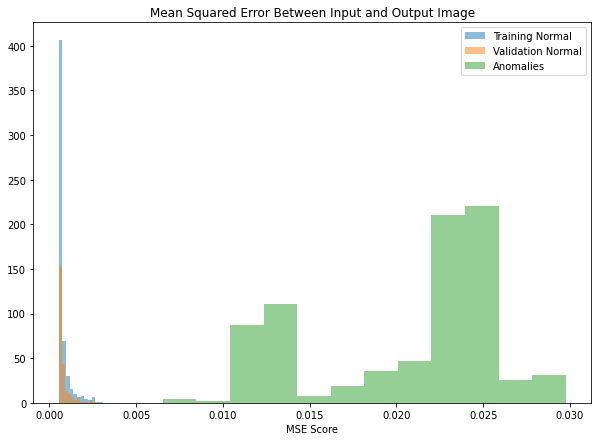

In [38]:
plt.figure(figsize = (10,7))
plt.title('Mean Squared Error Between Input and Output Image')
plt.hist(MSE_normal, 12, alpha=0.5, label='Training Normal')
plt.hist(MSE_val, 12, alpha=0.5, label='Validation Normal')
plt.hist(MSE_anom, 12, alpha=0.5, label='Anomalies')
plt.legend(loc='upper right')
plt.xlabel('MSE Score')

plt.show()

In [ ]:
# This function can be used for ingference when the system is deployed it checks one image at a time
def check_anomaly(img_path):
    # density_threshold = 0 
    reconstruction_error_threshold = 0.020
    img  = Image.open(img_path)
    img = np.array(img.resize((IMG_height, IMG_width), Image.ANTIALIAS))
    img = img / 255
    img = tf.expand_dims(img, 0)

    encoded_img = encoder_replica.predict(img) # Create a compressed version of the image using the encoder
    encoded_img = [np.reshape(img, (dim)) for img in encoded_img] # Flatten the compressed image
    density = kde.score_samples(encoded_img)[0] # get a density score for the new image
    print(f'density: {density}')
    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)
    print(f'reconstruction_error: {reconstruction_error}')
    if density < min_quantile_threshold or density > max_quantile_threshold or reconstruction_error > reconstruction_error_threshold:
        print("This image is anomaly")
    else:
        print("This image is normal")

In [ ]:
test_image = "/content/gdrive/My Drive/gpu_stress_encoder/train/gpu_stress_autoencoder/gpu_stress/FLIR3008Cropped.jpg"
check_anomaly(test_image)

density: -54.97375599007737
1/1 [==============================] - 0s 125ms/step - loss: 0.0405
reconstruction_error: 0.04049639776349068
This image is anomaly
